In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np

# 1. 自定义Dataset类，处理不等长序列
class MolecularDataset(Dataset):
    def __init__(self, input_sequences):
        self.input_sequences = input_sequences
        self.max_len = max(len(seq) for seq in input_sequences)  # 找到最长序列长度

    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, idx):
        sequence = self.input_sequences[idx]
        # 填充序列至最大长度
        padded_sequence = sequence + [[0] * len(sequence[0])] * (self.max_len - len(sequence))
        return torch.tensor(padded_sequence, dtype=torch.float32), len(sequence)

# 2. 定义一个Transformer模型来提取特征
class MolecularEmbeddingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_heads, num_layers):
        super(MolecularEmbeddingModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)  # 特征嵌入层
        self.transformer = nn.Transformer(
            d_model=embedding_dim,  # 输入维度
            nhead=num_heads,        # 注意力头的数量
            num_encoder_layers=num_layers  # Transformer层数
        )
        self.decoder = nn.Linear(embedding_dim, input_dim)  # 解码器，用于重建输入（自监督）

    def forward(self, x):
        # 将输入嵌入到更高维度
        embedded = self.embedding(x)
        # Transformer的输入需要是(batch_size, seq_len, embedding_dim)，
        # 但是transformer模型期望的输入是(seq_len, batch_size, embedding_dim)
        embedded = embedded.permute(1, 0, 2)  # 转换成 (seq_len, batch_size, embedding_dim)
        
        # 使用Transformer模型
        transformer_output = self.transformer(embedded)
        
        # 取Transformer输出的最后一层作为分子特征（或者你可以选择其他层的输出）
        return transformer_output[-1, :, :]  # 取最后一时刻的特征

# 3. 初始化数据和模型
# 示例数据，假设每个分子有3个特征 (E1, E2, E3) + 持续时间特征
input_sequences = [
    [[1.0, 2.0, 3.0, 10], [2.0, 3.0, 4.0, 20]],  # 长度为2
    [[2.0, 3.0, 4.0, 15], [3.0, 4.0, 5.0, 25], [4.0, 5.0, 6.0, 30]],  # 长度为3
    [[1.5, 2.5, 3.5, 12]]  # 长度为1
]

# 初始化Dataset和DataLoader
dataset = MolecularDataset(input_sequences)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

# 初始化模型
input_dim = 4  # 假设每个分子有4个特征（3个化学成分 + 1个持续时间）
embedding_dim = 128  # 特征嵌入维度
num_heads = 4  # 自注意力头数量
num_layers = 2  # Transformer层数
model = MolecularEmbeddingModel(input_dim, embedding_dim, num_heads, num_layers)

# 4. 模型前向传播并提取特征
model.eval()  # 设置为评估模式
with torch.no_grad():
    for batch_idx, (seq, seq_len) in enumerate(dataloader):
        output = model(seq)
        print(f"Batch {batch_idx+1} Output: {output.shape}")
        # 输出每个序列的分子特征（每个分子的嵌入表示）
        print(output)


d:\Software\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/50
Train Loss: 0.6547 | Val Loss: 0.0847
Epoch 2/50
Train Loss: 0.0757 | Val Loss: 0.0565
Epoch 3/50
Train Loss: 0.0606 | Val Loss: 0.0517
Epoch 4/50
Train Loss: 0.0533 | Val Loss: 0.0510
Epoch 5/50
Train Loss: 0.0426 | Val Loss: 0.0391
Epoch 6/50
Train Loss: 0.0375 | Val Loss: 0.0398
Epoch 7/50
Train Loss: 0.0363 | Val Loss: 0.0495
Epoch 8/50
Train Loss: 0.0348 | Val Loss: 0.0353
Epoch 9/50
Train Loss: 0.0324 | Val Loss: 0.0553
Epoch 10/50
Train Loss: 0.0336 | Val Loss: 0.0464
Epoch 11/50
Train Loss: 0.0326 | Val Loss: 0.0344
Epoch 12/50
Train Loss: 0.0334 | Val Loss: 0.0792
Epoch 13/50
Train Loss: 0.0333 | Val Loss: 0.0340
Epoch 14/50
Train Loss: 0.0291 | Val Loss: 0.0308
Epoch 15/50
Train Loss: 0.0305 | Val Loss: 0.0371
Epoch 16/50
Train Loss: 0.0295 | Val Loss: 0.0323
Epoch 17/50
Train Loss: 0.0288 | Val Loss: 0.0432
Epoch 18/50
Train Loss: 0.0331 | Val Loss: 0.0333
Epoch 19/50
Train Loss: 0.0298 | Val Loss: 0.0335
Epoch 20/50
Train Loss: 0.0276 | Val Loss: 0.0330
Epoch 21/

C:\Users\dfgje\AppData\Local\Temp\ipykernel_15860\1237410417.py:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


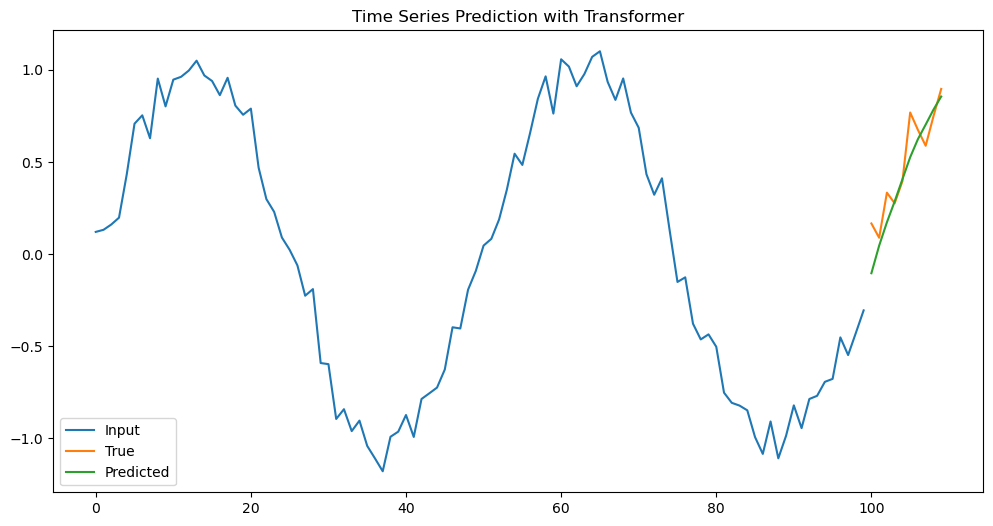

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# 超参数配置
class Config:
    seq_len = 100          # 输入序列长度
    pred_len = 10          # 预测序列长度
    batch_size = 32
    epochs = 50
    learning_rate = 0.001
    d_model = 128          # Transformer特征维度
    n_head = 4             # 多头注意力头数
    num_encoder_layers = 3 # Encoder层数
    num_decoder_layers = 3 # Decoder层数
    dropout = 0.1          
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 生成合成时间序列数据
def generate_time_series():
    freq = 0.02
    t = np.arange(3000)
    data = np.sin(2 * np.pi * freq * t) + 0.1 * np.random.randn(3000)
    return data.reshape(-1, 1)  # (seq_len, feature_dim)

# 自定义数据集
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len
    
    def __getitem__(self, idx):
        x = self.data[idx : idx+self.seq_len]
        y = self.data[idx+self.seq_len : idx+self.seq_len+self.pred_len]
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Transformer模型
class TimeSeriesTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # 输入投影层
        self.input_proj = nn.Linear(1, config.d_model)
        
        # 位置编码
        self.position_enc = PositionalEncoding(config.d_model, config.dropout)
        
        # Transformer
        self.transformer = nn.Transformer(
            d_model=config.d_model,
            nhead=config.n_head,
            num_encoder_layers=config.num_encoder_layers,
            num_decoder_layers=config.num_decoder_layers,
            dropout=config.dropout,
            batch_first=True
        )
        
        # 输出层
        self.output_proj = nn.Linear(config.d_model, 1)
        
    def forward(self, src, tgt):
        # src: (batch_size, seq_len, 1)
        # tgt: (batch_size, pred_len, 1)
        
        # 输入投影
        src = self.input_proj(src)  # (B, L, d_model)
        tgt = self.input_proj(tgt)
        
        # 位置编码
        src = self.position_enc(src)
        tgt = self.position_enc(tgt)
        
        # Transformer
        output = self.transformer(
            src, tgt,
            tgt_mask=nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(self.config.device)
        )
        # 输出投影
        output = self.output_proj(output)  # (B, pred_len, 1)
        
        return output

# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# 训练函数
def train(model, train_loader, criterion, optimizer, config):
    model.train()
    total_loss = 0
    
    for src, tgt in train_loader:
        src = src.to(config.device)  # (B, seq_len, 1)
        tgt = tgt.to(config.device)
        
        # 创建decoder输入
        decoder_input = torch.cat([src[:, -1:, :], tgt[:, :-1, :]], dim=1)
        
        optimizer.zero_grad()
        output = model(src, decoder_input)  # (B, pred_len, 1)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(train_loader)

# 验证函数
def validate(model, val_loader, criterion, config):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for src, tgt in val_loader:
            src = src.to(config.device)
            tgt = tgt.to(config.device)
            
            # 使用真实值作为decoder输入（teacher forcing）
            decoder_input = torch.cat([src[:, -1:, :], tgt[:, :-1, :]], dim=1)
            
            output = model(src, decoder_input)
            loss = criterion(output, tgt)
            total_loss += loss.item()
            
    return total_loss / len(val_loader)

# 主程序
if __name__ == "__main__":
    config = Config()
    
    # 准备数据
    data = generate_time_series()
    
    # 数据标准化
    train_data = data[:2000]
    val_data = data[2000:2500]
    test_data = data[2500:]
    
    mean = train_data.mean()
    std = train_data.std()
    train_data = (train_data - mean) / std
    val_data = (val_data - mean) / std
    test_data = (test_data - mean) / std
    
    # 创建数据集和数据加载器
    train_dataset = TimeSeriesDataset(train_data, config.seq_len, config.pred_len)
    val_dataset = TimeSeriesDataset(val_data, config.seq_len, config.pred_len)
    test_dataset = TimeSeriesDataset(test_data, config.seq_len, config.pred_len)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size)
    test_loader = DataLoader(test_dataset, batch_size=1)
    
    # 初始化模型
    model = TimeSeriesTransformer(config).to(config.device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    
    # 训练循环
    best_val_loss = float('inf')
    for epoch in range(config.epochs):
        train_loss = train(model, train_loader, criterion, optimizer, config)
        val_loss = validate(model, val_loader, criterion, config)
        
        print(f"Epoch {epoch+1}/{config.epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
    
    # 测试
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    
    # 在测试集上预测
    test_input, test_label = next(iter(test_loader))
    test_input = test_input.to(config.device)
    
    # 递归预测
    predictions = []
    decoder_input = test_input[:, -1:, :]  # 初始decoder输入
    
    with torch.no_grad():
        for _ in range(config.pred_len):
            output = model(test_input, decoder_input)
            predictions.append(output[:, -1, :])
            decoder_input = torch.cat([decoder_input, output[:, -1:, :]], dim=1)
    
    predictions = torch.cat(predictions, dim=1).cpu().numpy()
    
    # 反标准化
    test_input = test_input.cpu().numpy() * std + mean
    predictions = predictions * std + mean
    true_values = test_label.numpy() * std + mean
    
    # 可视化结果
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(config.seq_len), test_input[0], label="Input")
    plt.plot(np.arange(config.seq_len, config.seq_len+config.pred_len), true_values[0], label="True")
    plt.plot(np.arange(config.seq_len, config.seq_len+config.pred_len), predictions[0], label="Predicted")
    plt.legend()
    plt.title("Time Series Prediction with Transformer")
    plt.show()

In [1]:
# deepseek
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # (max_len, d_model)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, d_model]
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, d_model=64, nhead=8, num_layers=3, 
                 dim_feedforward=256, num_classes=1, max_seq_len=5000, dropout=0.1):
        super().__init__()
        
        # 输入投影层（4个特征转成d_model维度）
        self.input_proj = nn.Linear(4, d_model)
        
        # 位置编码
        self.pos_encoder = PositionalEncoding(d_model, max_seq_len, dropout)
        
        # Transformer编码器
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 输出层
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, src_key_padding_mask=None):
        """
        Args:
            x: 输入张量，形状 [batch_size, seq_len, 4]
            src_key_padding_mask: 掩码张量，形状 [batch_size, seq_len]
        """
        # 调整维度并投影 [seq_len, batch_size, d_model]
        x = x.permute(1, 0, 2)  # 转换为PyTorch Transformer需要的格式
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        
        # Transformer编码器处理 [seq_len, batch_size, d_model]
        transformer_out = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        
        # 全局平均池化 [batch_size, d_model]
        pooled = self.global_pool(transformer_out.permute(1, 2, 0)).squeeze(-1)
        
        # 全连接输出 [batch_size, num_classes]
        return self.fc(pooled)

# ------------------ 使用示例 ------------------
if __name__ == "__main__":
    # 超参数配置
    batch_size = 32
    max_seq_len = 100  # 实际使用时应为数据集中的最大序列长度
    d_model = 64
    num_classes = 1  # 假设是回归任务

    # 初始化模型
    model = TransformerModel(
        d_model=d_model,
        num_classes=num_classes,
        max_seq_len=max_seq_len
    )

    # 生成模拟数据
    x_demo = torch.randn(batch_size, max_seq_len, 4)  # 模拟批量数据
    mask = torch.zeros(batch_size, max_seq_len).bool()  # 模拟真实掩码（应由实际数据生成）

    # 前向传播
    output = model(x_demo, src_key_padding_mask=mask)
    print(f"输出形状: {output.shape}")  # 应该输出 torch.Size([32, 1])

d:\Software\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: The size of tensor a (32) must match the size of tensor b (100) at non-singleton dimension 1

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset

# Configuration
class Config:
    d_model = 64  # Transformer embedding size
    num_heads = 4  # Number of attention heads
    num_layers = 3  # Number of transformer layers
    d_ff = 256  # Feed-forward network size
    dropout = 0.1
    seq_len = 100  # Maximum sequence length
    num_features = 4  # Number of input features
    batch_size = 32
    epochs = 20
    learning_rate = 0.001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()

# Dataset with padding
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        self.data = [torch.tensor(d, dtype=torch.float32) for d in data]
        self.targets = [torch.tensor(t, dtype=torch.float32) for t in targets]
        self.max_len = max(len(d) for d in self.data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        pad_len = self.max_len - len(x)
        x = torch.cat([x, torch.zeros((pad_len, x.shape[1]))])
        y = torch.cat([y, torch.zeros((pad_len, y.shape[1]))])
        mask = torch.cat([torch.ones(len(self.data[idx])), torch.zeros(pad_len)])
        return x, y, mask

def collate_fn(batch):
    xs, ys, masks = zip(*batch)
    return torch.stack(xs), torch.stack(ys), torch.stack(masks)

# Transformer Model
class TransformerTimeSeries(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Linear(config.num_features, config.d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, config.seq_len, config.d_model))
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=config.d_model, nhead=config.num_heads, dim_feedforward=config.d_ff, dropout=config.dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=config.num_layers)
        self.fc = nn.Linear(config.d_model, config.num_features)
    
    def forward(self, x, mask):
        x = self.embedding(x) + self.positional_encoding[:, :x.shape[1], :]
        x = self.transformer(x, src_key_padding_mask=(mask == 0))
        return self.fc(x)

# Training function
def train_model(model, train_loader, config):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    model.to(config.device)
    
    for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        for x, y, mask in train_loader:
            x, y, mask = x.to(config.device), y.to(config.device), mask.to(config.device)
            optimizer.zero_grad()
            output = model(x, mask)
            loss = criterion(output * mask.unsqueeze(-1), y * mask.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{config.epochs}, Loss: {total_loss / len(train_loader)}")

# Prediction function
def predict(model, data, config):
    model.eval()
    with torch.no_grad():
        data_tensor = torch.tensor(data, dtype=torch.float32)  # Convert NumPy array to tensor
        x, _, mask = collate_fn([(data_tensor, torch.zeros_like(data_tensor), torch.ones(len(data_tensor)))])
        x, mask = x.to(config.device), mask.to(config.device)
        return model(x, mask).cpu().numpy()


# Example usage
if __name__ == "__main__":
    sample_data = [np.random.rand(np.random.randint(10, 100), 4) for _ in range(500)]
    sample_targets = [np.random.rand(len(d), 4) for d in sample_data]
    train_dataset = TimeSeriesDataset(sample_data, sample_targets)
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
    
    model = TransformerTimeSeries(config)
    train_model(model, train_loader, config)
    
    test_data = np.random.rand(50, 4)
    prediction = predict(model, test_data, config)
    print(prediction.shape)


Epoch 1/20, Loss: 0.09840462054125965
Epoch 2/20, Loss: 0.054290590109303594
Epoch 3/20, Loss: 0.05056877387687564
Epoch 4/20, Loss: 0.049310648115351796
Epoch 5/20, Loss: 0.04834112245589495
Epoch 6/20, Loss: 0.04810343845747411
Epoch 7/20, Loss: 0.04720382369123399
Epoch 8/20, Loss: 0.04724234319292009
Epoch 9/20, Loss: 0.04677603184245527
Epoch 10/20, Loss: 0.046481894329190254
Epoch 11/20, Loss: 0.04630055814050138
Epoch 12/20, Loss: 0.04605825408361852
Epoch 13/20, Loss: 0.04599026800133288
Epoch 14/20, Loss: 0.04598299413919449
Epoch 15/20, Loss: 0.045737077947705984
Epoch 16/20, Loss: 0.04555504722520709
Epoch 17/20, Loss: 0.04559924663044512
Epoch 18/20, Loss: 0.04576097032986581
Epoch 19/20, Loss: 0.04560619848780334
Epoch 20/20, Loss: 0.04549566376954317
(1, 50, 4)


d:\Software\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\transformer.py:409: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
